<a href="https://colab.research.google.com/github/mkdib1/University_PWs/blob/main/Asseignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES & PACKAGES

In [1]:
import zipfile
import os
from google.colab import drive
from time import time
import tarfile
from matplotlib import pyplot as plt
from scipy.io import wavfile as wav
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# FUNCTIONS

## Zero crossing rate

Here i propose two ZCR versions, each of them handles with the zeroes in a different way.

Specifically, `zcr` function aims not to consider zeroes along array values: zeroes are dropped out from the original array.

`zcr_1a` manages zeroes like a 'sign-reset' sentinel, meaning that it shut down sign memory of the previous value, starting sign comparison from scratch.  

In [2]:
def zcr(input):

    input_without_zero = [i for i in input if i != 0]
    cnt = 0

    for i in range(0,len(input_without_zero)-1):
      if input_without_zero[i] * input_without_zero[i+1] < 0:
        cnt += 1

    return np.array([cnt]) # transforming 'cnt' into vectorial np.array in order to fit with model building requests


In [3]:
def zcr_1a(input):

    cnt = 0
    for i in range(0,len(input)-1):
      if input[i] * input[i+1] == 0:
        continue
      elif input[i] * input[i+1] < 0:
        cnt += 1

    return np.array([cnt]) # transforming 'cnt' into vectorial np.array in order to fit with model building requests


It follows a group of function seen during theoretical lecturers, which are used into `mult_feat_array`: it aimes to build an array of features, including ZCR (both using `zcr` first, and then`zcr_1a` versions of ZCR).

## Energy

In [4]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

## Duration

In [5]:
def duration(input):
    return np.array(input.shape)

## Mean

In [6]:
def mean_val(input):
    return np.mean(input, keepdims=True)

## Standard deviation

In [7]:
def sdev(input):
    return np.std(input, keepdims=True)

## Multiple features array

In [8]:
def mult_feat_array(input):

    output = np.concatenate([zcr(input),
                             energy(input),
                             duration(input)
                             ,mean_val(input),
                             sdev(input)],
                             axis=0)

    return output

In [9]:
def mult_feat_array_1a(input):

    output = np.concatenate([zcr_1a(input),
                             energy(input),
                             duration(input)
                             ,mean_val(input),
                             sdev(input)],
                             axis=0)

    return output

## Dataloader

In [10]:
# Placecholder for feature extractor
def identity(input):
    return input


# Defining data loader function
def load_data(feature_extractor, normalize=False):

    # inizializing lists for saving classes and features values
    labels = []
    features = []

    directory = '/content/drive/MyDrive/audio_unzipped/recordings/'
    for f in sorted(os.listdir(directory)): # reading .wav files from dir
        if f.endswith('.wav'):

            _, signal = wav.read(directory + f)  # saving signal into 'signal' var
            cur_features = feature_extractor(signal)
            features.append(cur_features) # appending computed feature over each array onto 'features' list


            label = f.split('_')[0]  # saving classes values
            labels.append(label)

    # Splitting observations into train and test set, 80% sv 20% size respectively
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001 # stabilizer param
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps) # normailzing values aroung train set mean and std
        X_train = [row for row in X_train]
        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)] # using mean and std to normalize test set too

    return X_train, X_test, y_train, y_test

## Confusion matrix builder

In [11]:
def plot_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred) # building the confusion matrix

    # Display settings
    y_true_labels = np.unique(y_true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true_labels)
    disp.plot(cmap='Blues', values_format='d')

    # Graph settings
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Model fitter & evaluator

The function below can be called on demand by specifying a custom feature extractor. The function will perform data loading by using `load_data` and print the classification report, as well as plot the confusion matrix.<br>
I decided not to print the entire classification indicators, saving and reporting the accuracy measure only.

In [12]:
def train_and_evaluate_svm_with_graphs(feature_extractor, normalize=False, kernel='rbf', class_weight='balanced'):

    X_train, X_test, y_train, y_test = load_data(feature_extractor, normalize=normalize) # loading data choosing custom feature extractor

    svm_clsf = None
    svm_clsf = SVC(kernel=kernel, class_weight=class_weight) # model definition
    svm_clsf.fit(X_train, y_train) # training the model (Support vector machine)

    y_pred = svm_clsf.predict(X_test) # computing test_set prediction
    print("---"*10)
    print("accuracy score: ", round(accuracy_score(y_test, y_pred),2)) # printing the accuracy
    print("---"*10)

    # Building confusion matrix through defining visual settings
    plot_confusion_matrix(y_test, y_pred)

# MAIN

In [13]:
drive.mount('/content/drive')
tar_path = '/content/drive/MyDrive/recordings.tar'

Mounted at /content/drive


In [14]:
# with tarfile.open(tar_path, 'r') as tar_ref:
#    tar_ref.extractall('/content/drive/MyDrive/audio_unzipped')

In [15]:
# shutil.rmtree('/content/drive/MyDrive/audio_unzipped')

The following section of the **MAIN** is related to the run of the model by using:
* different feature extractor (zcr function versions vs array of features function)
* row data vs data normalization model estimation

## Prediction: SVM application

### 1) ZCR only

#### `zcr`, normalize=False

<ipython-input-2-17c0d36bf120>:7: RuntimeWarning: overflow encountered in scalar multiply
  if input_without_zero[i] * input_without_zero[i+1] < 0:


------------------------------
accuracy score:  0.17
------------------------------


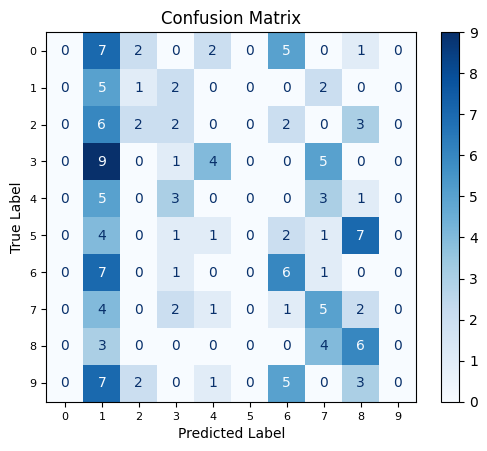

In [16]:
train_and_evaluate_svm_with_graphs(feature_extractor=zcr)

#### `zcr`, normalize=True

<ipython-input-2-17c0d36bf120>:7: RuntimeWarning: overflow encountered in scalar multiply
  if input_without_zero[i] * input_without_zero[i+1] < 0:


------------------------------
accuracy score:  0.17
------------------------------


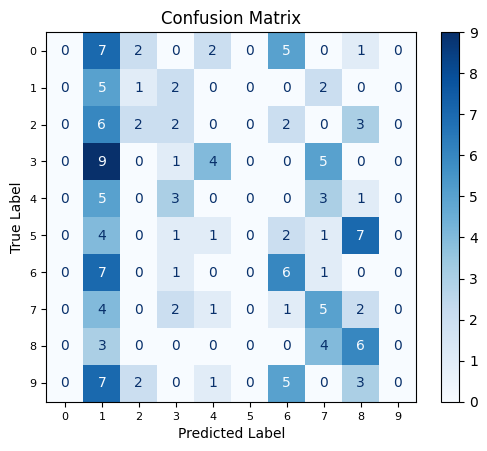

In [17]:
train_and_evaluate_svm_with_graphs(feature_extractor=zcr, normalize=True)

#### `zcr_1a`, normalize=False

<ipython-input-3-a778487db5fb>:5: RuntimeWarning: overflow encountered in scalar multiply
  if input[i] * input[i+1] == 0:
<ipython-input-3-a778487db5fb>:7: RuntimeWarning: overflow encountered in scalar multiply
  elif input[i] * input[i+1] < 0:


------------------------------
accuracy score:  0.17
------------------------------


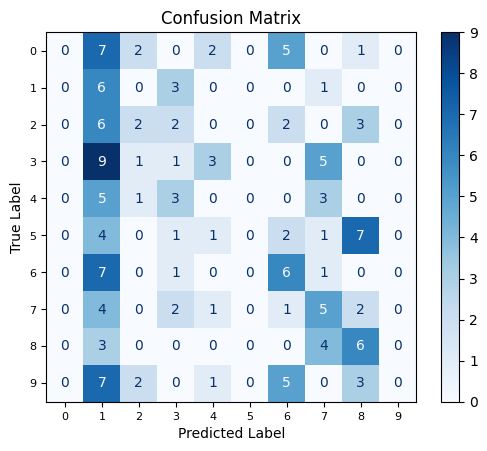

In [18]:
train_and_evaluate_svm_with_graphs(feature_extractor=zcr_1a)

#### `zcr_1a`, normalize=True

<ipython-input-3-a778487db5fb>:5: RuntimeWarning: overflow encountered in scalar multiply
  if input[i] * input[i+1] == 0:
<ipython-input-3-a778487db5fb>:7: RuntimeWarning: overflow encountered in scalar multiply
  elif input[i] * input[i+1] < 0:


------------------------------
accuracy score:  0.17
------------------------------


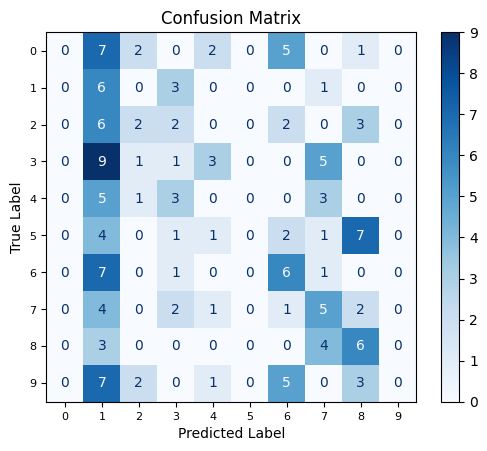

In [19]:
train_and_evaluate_svm_with_graphs(feature_extractor=zcr_1a, normalize=True)

As observed, both versions of the ZCR function yield an identical accuracy score of 17%, no matter if data were normalized nor if a specific ZCR function version used.<br> Furthermore, the model seems to reproduce the same prediction pattern, as suggested by the results of the confusion matrices which are overlapping to each other.

More in details:

* the model seems to ignore the learning of digits 0, 5, and 9.
* there appears to be a ‘digit 1 fixation’ effect, since the model predicts 1 across various digit classes.
* the digits with the highest accuracy in prediction are 1, 6, and 8, each correctly classified six times.

### 2) Multiple features array

#### normalize=False

<ipython-input-2-17c0d36bf120>:7: RuntimeWarning: overflow encountered in scalar multiply
  if input_without_zero[i] * input_without_zero[i+1] < 0:


------------------------------
accuracy score:  0.19
------------------------------


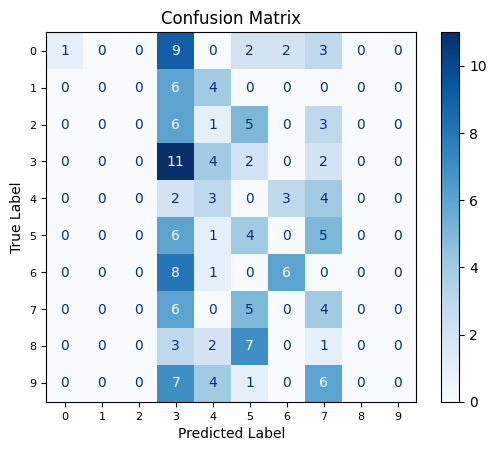

In [20]:
train_and_evaluate_svm_with_graphs(feature_extractor=mult_feat_array)

#### normalize=True

<ipython-input-2-17c0d36bf120>:7: RuntimeWarning: overflow encountered in scalar multiply
  if input_without_zero[i] * input_without_zero[i+1] < 0:


------------------------------
accuracy score:  0.39
------------------------------


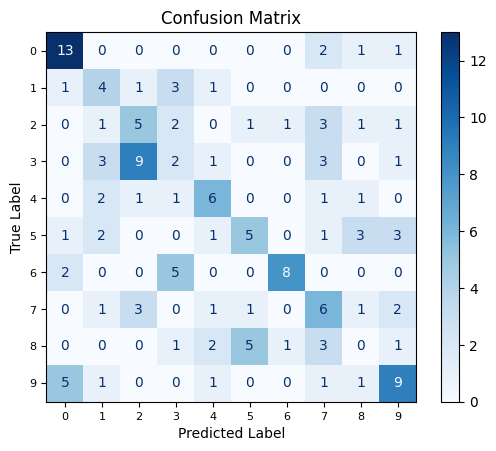

In [21]:
train_and_evaluate_svm_with_graphs(feature_extractor=mult_feat_array, normalize=True)

<ipython-input-3-a778487db5fb>:5: RuntimeWarning: overflow encountered in scalar multiply
  if input[i] * input[i+1] == 0:
<ipython-input-3-a778487db5fb>:7: RuntimeWarning: overflow encountered in scalar multiply
  elif input[i] * input[i+1] < 0:


------------------------------
accuracy score:  0.19
------------------------------


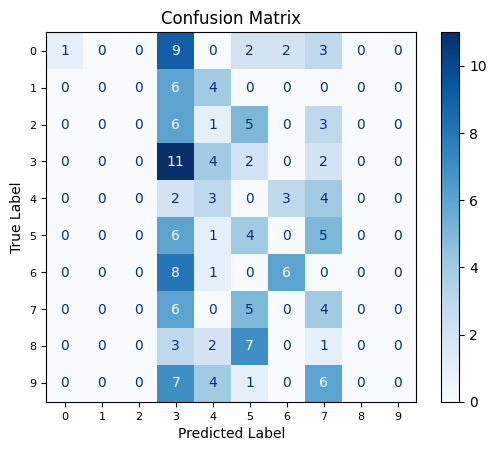

In [22]:
train_and_evaluate_svm_with_graphs(feature_extractor=mult_feat_array_1a)

<ipython-input-3-a778487db5fb>:5: RuntimeWarning: overflow encountered in scalar multiply
  if input[i] * input[i+1] == 0:
<ipython-input-3-a778487db5fb>:7: RuntimeWarning: overflow encountered in scalar multiply
  elif input[i] * input[i+1] < 0:


------------------------------
accuracy score:  0.39
------------------------------


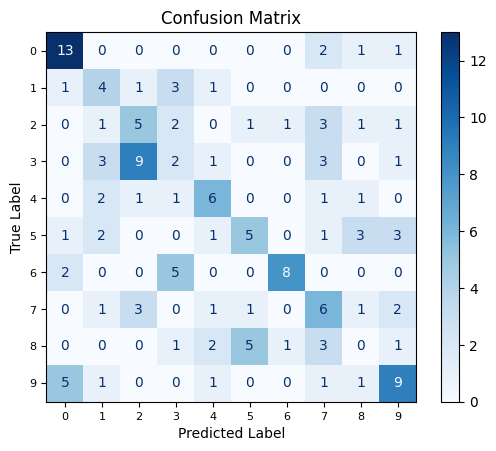

In [23]:
train_and_evaluate_svm_with_graphs(feature_extractor=mult_feat_array_1a, normalize=True)

Using the feature array as a feature extractor provides interesting suggestions:

* a significant improvement is observed with data normalization, increasing accuracy from 19% to 39%.
* both versions of the function leads to overlapping results.
* with data normalization, the bias associated with overlooking the digits 0, 5, and 9 is eliminated.

In conclusion, increasing the number of features considered leads to better model performance.

# Tuning degli iperparametri

In [ ]:
# Definiamo una griglia di parametri. La SVM si serve di due
# iperparametri, C e gamma.
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.05, 0.5, 0.1, 0.01, 0.005]}

# Applichiamo una grid search, con cross-validation = 2
clf_gs = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
clf_gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=2, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [100, 500, 1000],
                         'gamma': [0.05, 0.5, 0.1, 0.01, 0.005]})

Ci ritorna graficamente un output carino con i best_parameters, che sono
*C=500* e *gamma=0.05*

In [ ]:
# Gli stessi, possono anche essere richiamati così:
clf_gs.best_estimator_.C
clf_gs.best_estimator_.gamma

0.05

Vediamone le performances

In [ ]:
y_pred_gs = clf_gs.predict(X_test)
print(classification_report(y_test, y_pred_gs))

              precision    recall  f1-score   support

           0       0.53      0.59      0.56        17
           1       0.47      0.70      0.56        10
           2       0.24      0.60      0.34        15
           3       0.46      0.32      0.38        19
           4       0.17      0.18      0.17        11
           5       0.17      0.07      0.10        14
           6       0.30      0.43      0.35        14
           7       0.25      0.16      0.19        19
           8       0.14      0.06      0.08        17
           9       0.50      0.29      0.36        14

    accuracy                           0.33       150
   macro avg       0.32      0.34      0.31       150
weighted avg       0.32      0.33      0.30       150

